In [ ]:
!pip install pydicom
!pip install pydicom-seg
!pip install dicom2nifti

In [ ]:
import numpy as np 
import os
import copy
from math import *
import matplotlib.pyplot as plt
from functools import reduce

# dicom files
import pydicom
import pydicom_seg
import SimpleITK as sitk

# skimage image processing packages
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops

# scipy linear algebra functions 
from scipy.linalg import norm
import scipy.ndimage

# ipywidgets for some interactive plots
from ipywidgets.widgets import * 
import ipywidgets as widgets

# plotly 3D interactive graphs 
import plotly
from plotly.graph_objs import *

# zip
import zipfile
from shutil import copyfile, rmtree
import dicom2nifti

In [ ]:
def main(mask=None):
    ct_path = path = "/content/drive/MyDrive/tcia-download/NSCLC-Radiomics/CT"
    seg_path = path = "/content/drive/MyDrive/tcia-download/NSCLC-Radiomics/SEG"
    valid_files = sorted(set(os.listdir(ct_path)) & set(os.listdir(seg_path)))
    for filename in valid_files:
        patient_ID = int(filename.split(".")[0])
        print(f"Patient ID = {patient_ID}")
        if (mask is None) or (patient_ID in mask): 
            ct_filepath = os.path.join(ct_path, filename)
            seg_filepath = os.path.join(seg_path, filename)

            # dicom 2 nii.gz
            with zipfile.ZipFile(ct_filepath, 'r') as zip_ref:
                zip_ref.extractall("./temp/CT")
            os.mkdir("./CT/"+str(patient_ID))
            try:
                dicom2nifti.convert_directory("./temp/CT", "./CT/"+str(patient_ID))
                dicom_name = "./CT/CT-"+str(patient_ID)+".nii.gz"
                os.rename("./CT/"+str(patient_ID)+"/"+os.listdir("./CT/"+str(patient_ID))[0] , dicom_name)
                rmtree("./CT/"+str(patient_ID))
            except:
                pass

            # seg 2 nii.gz
            with zipfile.ZipFile(seg_filepath, 'r') as zip_ref:
                zip_ref.extractall("./temp/SEG")
            # print("Converting SEG to .nii.gz ......")
            path = "./temp/SEG"
            seg = pydicom.dcmread(path + '/' + os.listdir(path)[0])
            reader = pydicom_seg.SegmentReader()
            result = reader.read(seg)
            
            # selecting the correct segment (Tumor: neoplasm)
            neoplasm_index = None
            for i in result.available_segments:
                if "neoplasm" in result.segment_infos[i].SegmentLabel.lower():
                    neoplasm_index = i
                    break
            print(f"Neoplasm Index: {neoplasm_index} | label: {result.segment_infos[i].SegmentLabel}")
            
            # saving segmentation
            image = result.segment_image(neoplasm_index)  # lazy construction
            sitk.WriteImage(image, f'./SEG/SEG-{patient_ID}.roi.nii.gz', True)
            rmtree("./temp/")

In [ ]:
!mkdir CT
!mkdir SEG
!rm -rf temp
!rm -rf CT/*
!rm -rf SEG/*

mkdir: cannot create directory ‘CT’: File exists
mkdir: cannot create directory ‘SEG’: File exists


In [ ]:
!du -sh ./SEG

15M	./SEG


In [ ]:
# !rm -rf temp
main()

In [ ]:
ID = "001"

CTsrc = "/content/drive/MyDrive/tcia-download/NSCLC-Radiomics/CT/"+ ID + ".zip"
CTdst = "./CT" + ID + ".zip"

SEGsrc = "/content/drive/MyDrive/tcia-download/NSCLC-Radiomics/SEG/"+ ID + ".zip"
SEGdst = "./SEG" + ID + ".zip"

In [ ]:
copyfile(CTsrc, CTdst)
copyfile(SEGsrc, SEGdst)

'./SEG001.zip'

In [ ]:
with zipfile.ZipFile(CTdst, 'r') as zip_ref:
    zip_ref.extractall("./CT")

In [ ]:
with zipfile.ZipFile(SEGdst, 'r') as zip_ref:
    zip_ref.extractall("./SEG")

In [ ]:
!zip -r ./CT.zip ./CT

  adding: CT/ (stored 0%)
  adding: CT/CT-389.nii.gz (deflated 0%)
  adding: CT/CT-418.nii.gz (deflated 0%)
  adding: CT/CT-77.nii.gz (deflated 0%)
  adding: CT/CT-388.nii.gz (deflated 0%)
  adding: CT/CT-90.nii.gz (deflated 0%)
  adding: CT/CT-176.nii.gz (deflated 0%)
  adding: CT/CT-204.nii.gz (deflated 0%)
  adding: CT/CT-58.nii.gz (deflated 0%)
  adding: CT/CT-370.nii.gz (deflated 0%)
  adding: CT/CT-162.nii.gz (deflated 0%)
  adding: CT/CT-40.nii.gz (deflated 0%)
  adding: CT/CT-3.nii.gz (deflated 0%)
  adding: CT/CT-236.nii.gz (deflated 0%)
  adding: CT/CT-380.nii.gz (deflated 0%)
  adding: CT/CT-37.nii.gz (deflated 0%)
  adding: CT/CT-102.nii.gz (deflated 0%)
  adding: CT/CT-385.nii.gz (deflated 0%)
  adding: CT/CT-255.nii.gz (deflated 0%)
  adding: CT/CT-54.nii.gz (deflated 0%)
  adding: CT/CT-211.nii.gz (deflated 0%)
  adding: CT/CT-421.nii.gz (deflated 0%)
  adding: CT/CT-123.nii.gz (deflated 0%)
  adding: CT/CT-186.nii.gz (deflated 0%)
  adding: CT/CT-169.nii.gz (deflated 0%

In [ ]:
!zip -r ./SEG.zip ./SEG

In [ ]:
!cp -r ./SEG /content/drive/MyDrive/tcia-download/NSCLC-Radiomics/SEG-nii

In [ ]:
!cp -r ./CT /content/drive/MyDrive/tcia-download/NSCLC-Radiomics/CT-nii

## CT

In [ ]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)    
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

In [ ]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0 
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

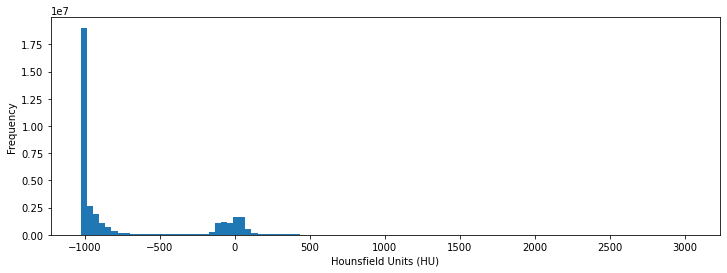

In [ ]:
first_patient = load_scan("./CT")
first_patient_pixels = get_pixels_hu(first_patient)

# Plotting
plt.figure(figsize=(12,4))
plt.hist(first_patient_pixels.flatten(), bins=100)
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# # Sanity Check
# plt.imshow(first_patient_pixels[80], cmap=plt.cm.bone)
# plt.show()

In [ ]:
plt.figure(figsize=(10,10))
def dicom_animation(x):
    plt.imshow(first_patient_pixels[x], cmap=plt.cm.bone)
    return x
interact(dicom_animation, x=(0, len(first_patient_pixels)-1))

<Figure size 720x720 with 0 Axes>

interactive(children=(IntSlider(value=66, description='x', max=133), Output()), _dom_classes=('widget-interact…

<function __main__.dicom_animation>

## SEGMENTATION

In [ ]:
path = "./SEG"
seg = pydicom.dcmread(path + '/' + os.listdir(path)[0])
reader = pydicom_seg.SegmentReader()
result = reader.read(seg)

In [ ]:
result.available_segments

{1, 2, 3, 4}

In [ ]:
result.segment_infos[1].SegmentLabel

'Neoplasm, Primary'

In [ ]:
# for segment_number in result.available_segments:
#     image_data = result.segment_data(segment_number)  # directly available
#     image = result.segment_image(segment_number)  # lazy construction
#     sitk.WriteImage(image, f'/tmp/seg-{segment_number}.nrrd', True)
image_data = result.segment_data(1)  # directly available
image = result.segment_image(1)  # lazy construction
sitk.WriteImage(image, './002/SEG/seg2.nii.gz', True)

In [ ]:
img = result.segment_data(1)
def dicom_animation(x):
    plt.figure(figsize=(8,8))
    plt.imshow(first_patient_pixels[x], cmap=plt.cm.bone)
    plt.imshow(img[x], cmap='jet', alpha=0.5)
    plt.show()
    return x
interact(dicom_animation, x=(0, len(first_patient_pixels)-1))

interactive(children=(IntSlider(value=66, description='x', max=133), Output()), _dom_classes=('widget-interact…

<function __main__.dicom_animation>